In [1]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from clean_data import load_and_clean_data
from preprocess_data import preprocess_data
import Datasets

# Paths to data
properties_2016_path = '../Group10/Datasets/properties_2016.csv'
train_2016_path = '../Group10/Datasets/train_2016_v2.csv'
properties_2017_path = '../Group10/Datasets/properties_2017.csv'
train_2017_path = '../Group10/Datasets/train_2017.csv'

# Load and clean data
df_train = load_and_clean_data(properties_2016_path, train_2016_path, properties_2017_path, train_2017_path)







In [3]:
# Preprocess the data
X_processed, y, preprocessor = preprocess_data(df_train)


In [5]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


In [7]:
# Initialize the model
model = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)




In [9]:
# Evaluate the model
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train MAE: {mae_train}")
print(f"Test MAE: {mae_test}")
print(f"Train MSE: {mse_train}")
print(f"Test MSE: {mse_test}")
print(f"Train R2: {r2_train}")
print(f"Test R2: {r2_test}")


Train MAE: 0.030594988981160406
Test MAE: 0.07943205585726819
Train MSE: 0.004587830350725696
Test MSE: 0.031144158499212392
Train R2: 0.8310213574705902
Test R2: -0.08562400097365686


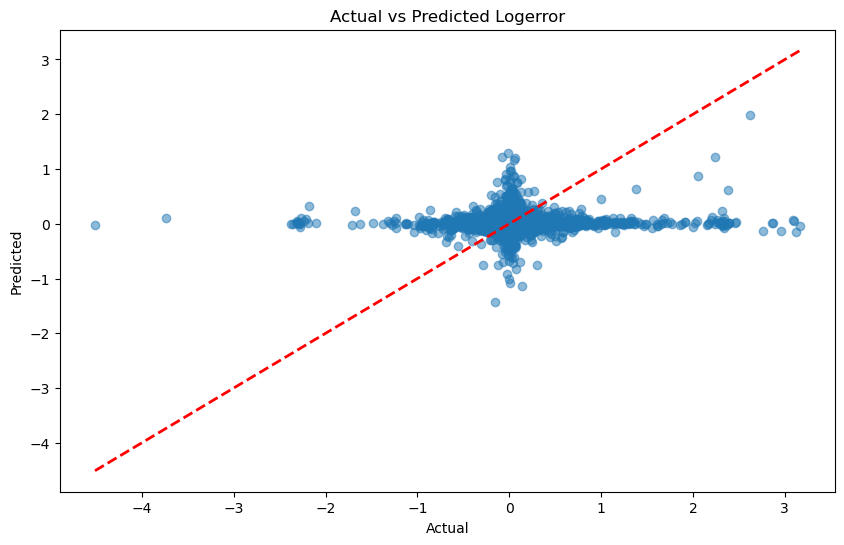

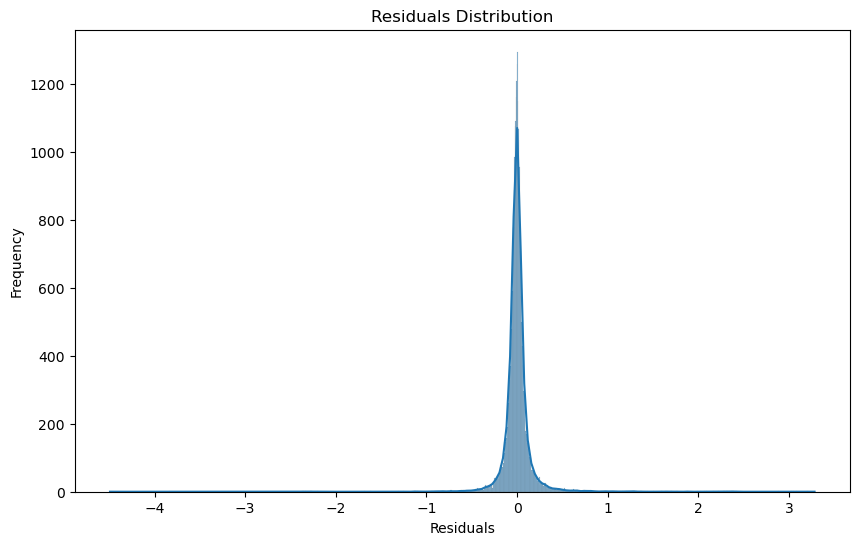

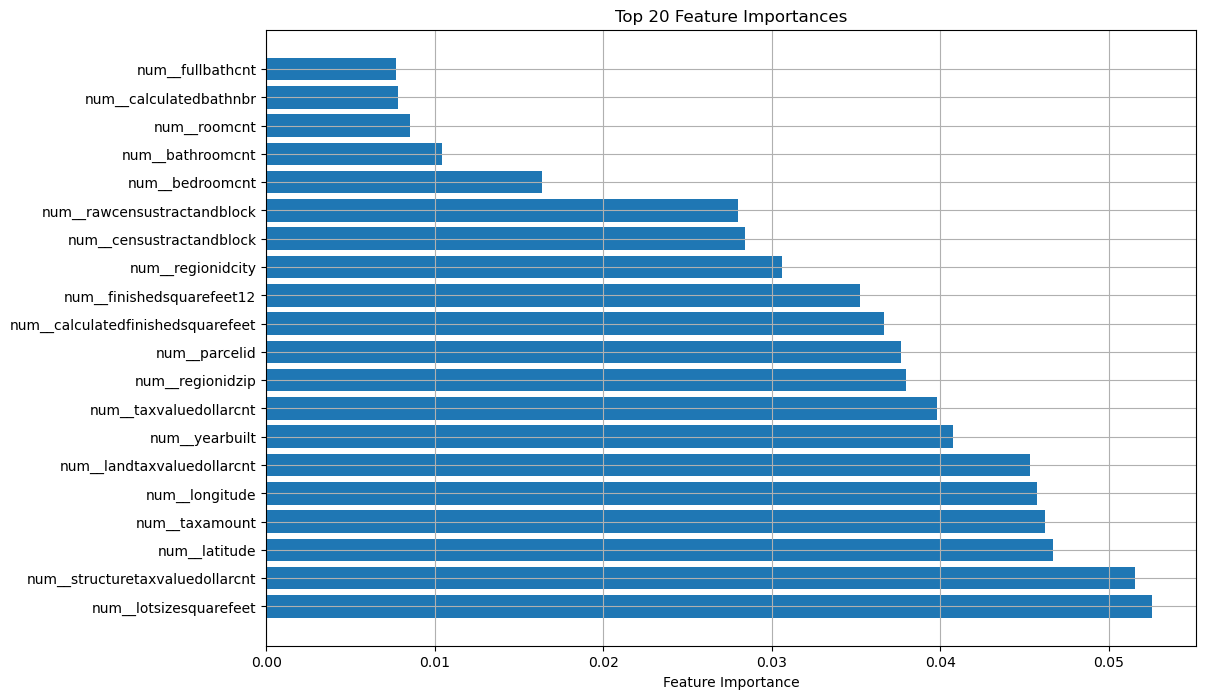

In [11]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Logerror')
plt.show()

# Residual plot
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

# Feature importance plot
importances = model.feature_importances_
features = preprocessor.get_feature_names_out()
sorted_indices = importances.argsort()[::-1]
top_indices = sorted_indices[:20]  # Top 20 features

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_indices)), importances[top_indices], align='center')
plt.yticks(range(len(top_indices)), [features[i] for i in top_indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.grid(True)
plt.show()


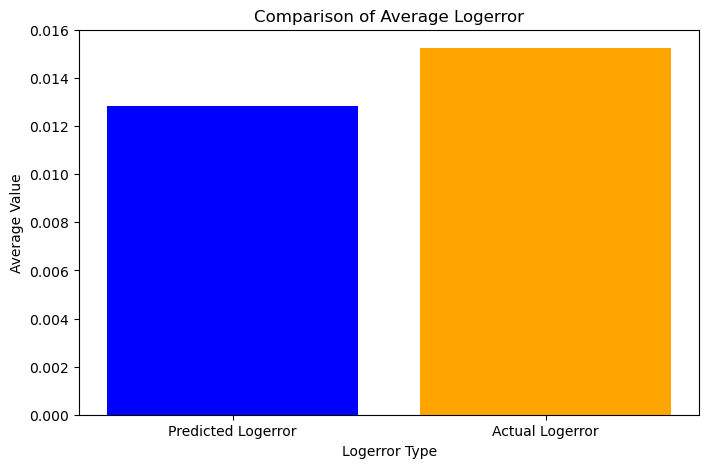

-15.83169859865998
0.012829359461553494 0.015242507271685586


In [13]:
# Calculate average logerror for predicted and actual values
avg_predicted_logerror = y_pred_test.mean()
avg_actual_logerror = y_test.mean()
# Optional: Plot comparison of average logerror
plt.figure(figsize=(8, 5))
plt.bar(['Predicted Logerror', 'Actual Logerror'], [avg_predicted_logerror, avg_actual_logerror], color=['blue', 'orange'])
plt.xlabel('Logerror Type')
plt.ylabel('Average Value')
plt.title('Comparison of Average Logerror')
plt.show()
# Calculate the percentage difference
print(((avg_predicted_logerror - avg_actual_logerror)/avg_actual_logerror)*100)
print(avg_predicted_logerror, avg_actual_logerror)